# Feature Construction Using Interictal Data

ii data will be markedly different from ictal data in that their is not time variation around onset.

In [1]:
cd ../../

/Users/adam2392/Documents/interictal_study


In [2]:
import os
import re
import json
import collections
from pprint import pprint
from pathlib import Path
import sys

import numpy as np
import pandas as pd
import scipy
import scipy.io
from natsort import natsorted, index_natsorted

import matplotlib.pyplot as plt
import seaborn as sns

import mne
from mne_bids import read_raw_bids, BIDSPath, get_entities_from_fname, get_entity_vals

from eztrack.io import read_clinical_excel
from eztrack.viz import generate_heatmap, _load_turbo
_load_turbo()

from ezinterictal.io.read import load_all_interictal_derivatives

# import statistics packages
import scipy.stats

import matplotlib
from matplotlib.colors import LogNorm
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
# Say, "the default sans-serif font is COMIC SANS"
matplotlib.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "arial"

from mlxtend.evaluate import bootstrap_point632_score
import pingouin as pg
import dabest

from itertools import chain

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Load in all the Data

In [3]:
root = Path('/Users/adam2392/Dropbox/epilepsy_bids/')
deriv_root = root / 'derivatives' / 'interictal'

# metadata table
excel_fpath = Path(
    "/home/adam2392/hdd2/Dropbox/epilepsy_bids/sourcedata/organized_clinical_datasheet_raw.xlsx"
)
excel_fpath = root / 'sourcedata/organized_clinical_datasheet_raw.xlsx'

# BIDS entities
session = "presurgery"
acquisition = "seeg"
task = "interictal"
datatype = "ieeg"
reference = 'monopolar'
resample = False

feature_name = 'fragility'
description = 'perturbmatrix'

# what sample to start in the interictal derivative
start = 100

# how many samples to go beyond the interictal derivative
num_samples = 40

if resample is False:
    sfreq = 'originalsampling'
else:
    sfreq = resample
    
deriv_chain = Path(sfreq) / feature_name / reference

In [4]:
deriv_path = deriv_root / deriv_chain
subjects = get_entity_vals(deriv_path, 'subject', ignore_tasks=['ictal'], ignore_datatypes=['eeg'])

# load all interictal results
interictal_results, subject_groups = load_all_interictal_derivatives(deriv_root=deriv_path,
                                                                    datatype=datatype,
                                                                    desc=description, verbose=False)

pat_df = read_clinical_excel(excel_fpath, keep_as_df=True)

In [6]:
sns.set_context('paper', font_scale=1.5)

'chs'
<Derivative | sub-jh103_ses-presurgery_task-interictal_acq-ecog_run-02_desc-perturbmatrix_ieeg.npy, 88 x 1376 (1375.0 s), ~961 kB>
[100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139]
'chs'
<Derivative | sub-jh103_ses-presurgery_task-interictal_acq-ecog_run-02_desc-rowperturbmatrix_ieeg.npy, 88 x 1376 (1375.0 s), ~961 kB>
[100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139]
'chs'
<Derivative | sub-jh103_ses-presurgery_task-interictal_acq-ecog_run-01_desc-rowperturbmatrix_ieeg.npy, 88 x 1239 (1238.0 s), ~867 kB>
[100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139]
'chs'
<Derivative | sub-jh103_ses-presurgery_task-interictal_acq-ecog_run-01_desc-perturbma

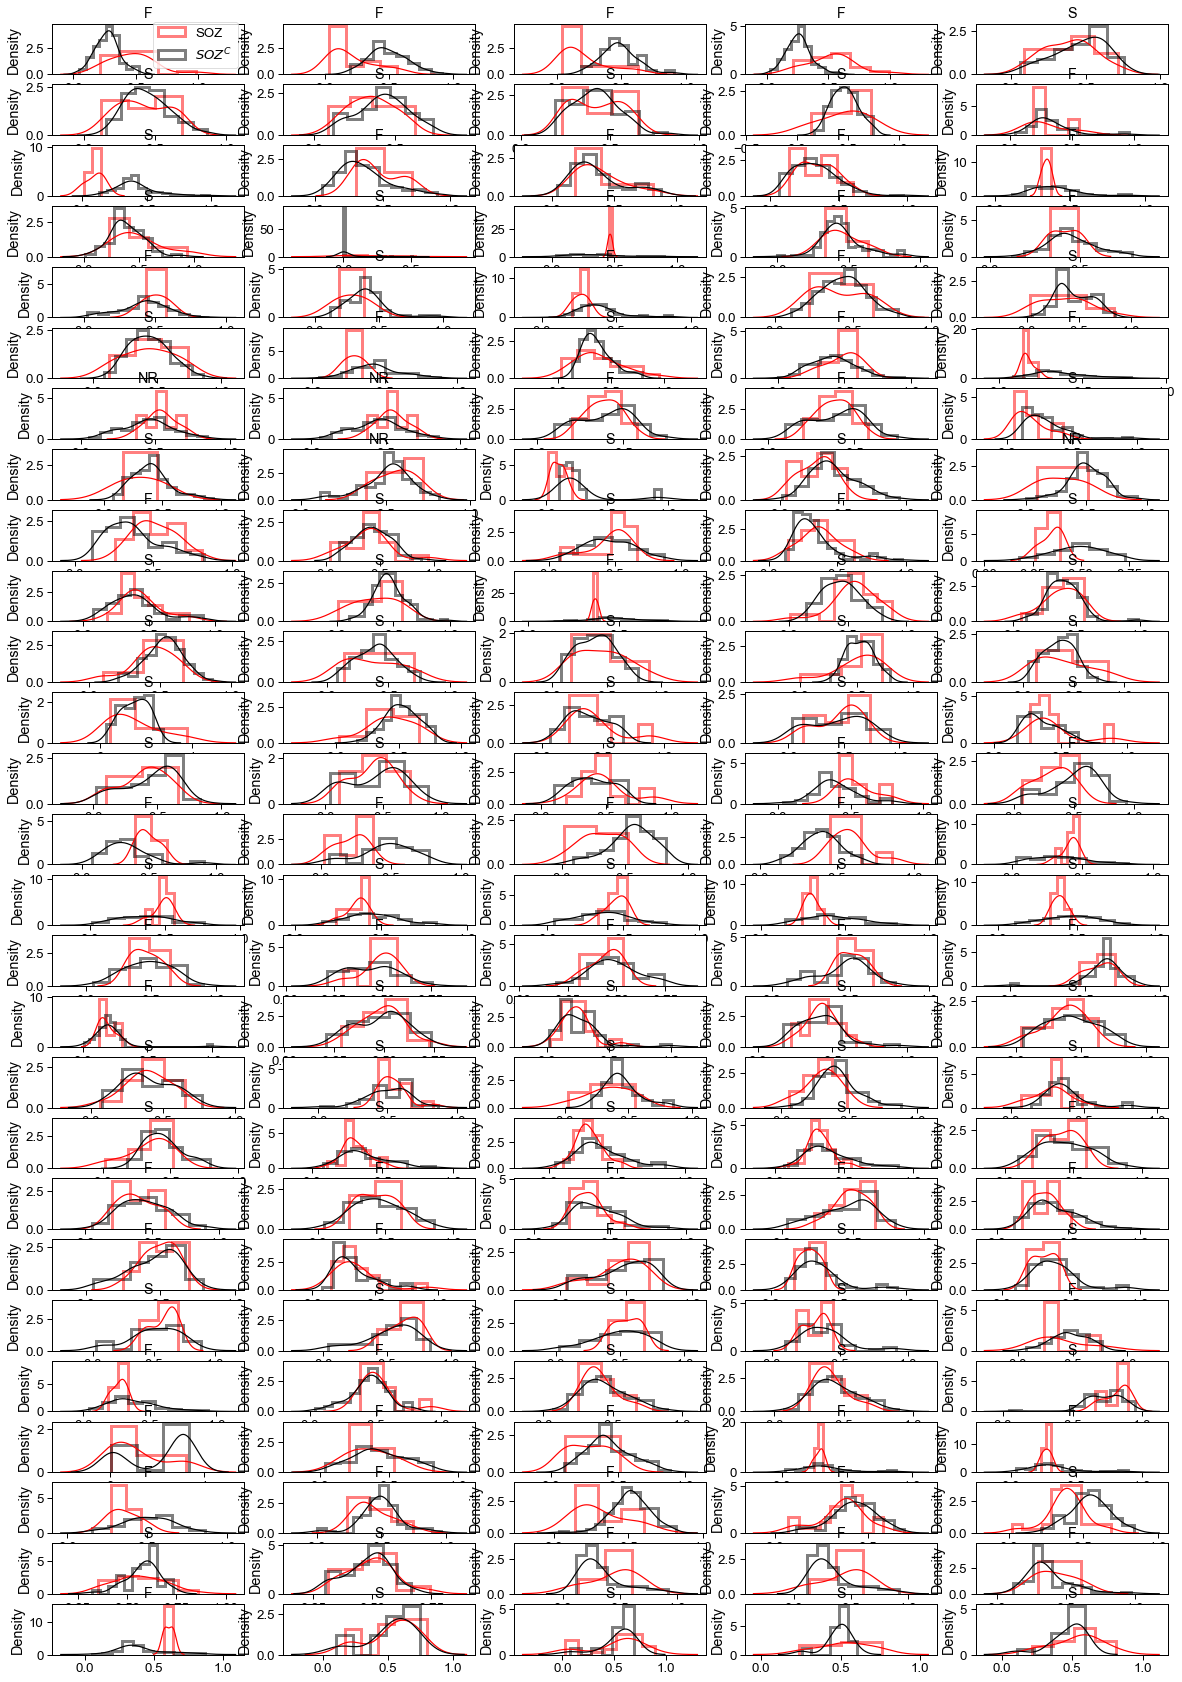

In [8]:
outcomes = []

fig, axs = plt.subplots(len(interictal_results) // 5, 5, figsize=(20, 30))
axs = axs.flat

# slice data in time
for idx, deriv in enumerate(interictal_results):
    deriv.normalize()
    
    # get the fragility matrix and channel names
    fragmat, times = deriv.get_data(start=start, stop=start+num_samples, return_times=True)
    ch_names = deriv.ch_names

    # optionally apply svd
    
    # optionally threshold
    
    # average in time
    fragmat = np.mean(fragmat, axis=1)
    
    # get soz indices and nsoz indices
    source_entities = deriv.info.source_entities
    subject = source_entities['subject']
    
    # use excel file to set various data points
    pat_row = pat_df[pat_df['PATIENT_ID'] == subject.upper()]
    outcome = pat_row['OUTCOME'].values[0]
    outcomes.append(outcome)
    soz_chs = pat_row['SOZ_CONTACTS'].values[0]
    
    soz_inds = [idx for idx, ch in enumerate(ch_names) if ch.upper() in soz_chs]
    nsoz_inds = [idx for idx in range(len(ch_names)) if idx not in soz_inds]
    
    # split vector into SOZ and nSOZ
    soz_frag = fragmat[soz_inds, ...]
    nsoz_frag = fragmat[nsoz_inds, ...]
    
#     print(soz_frag.shape, nsoz_frag.shape)
    ax = axs[idx]
    ax = sns.distplot(soz_frag, ax=ax, color='red', label='SOZ',
                 hist_kws={"histtype": "step", "linewidth": 3,
                            "alpha": 0.5, "color": "red"})
    ax = sns.distplot(nsoz_frag, ax=ax, color='black', label='$SOZ^C$',
                hist_kws={"histtype": "step", 
                          "linewidth": 3,
                            "alpha": 0.5, 
                          "color": "black"
                         })
    ax.set(
#         title=Path(deriv.filenames[0]).stem + f' ({outcome})',
        title = outcome,
    )
    if idx == 0:
        ax.legend()
        ax.set(xlabel='Fragility Value')
    
    print(deriv)
    print(times)
#     break

In [11]:
print(pert_mat.shape)

(88, 40)
